In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import time

## Load dataset and create dataframes

In [3]:
# Load datasets
train_df = pd.read_csv("../datasets/layer-7/train.csv")
valid_df= pd.read_csv("../datasets/layer-7/valid.csv")
test_df = pd.read_csv("../datasets/layer-7/test.csv")

In [7]:
train_df.shape, valid_df.shape, test_df.shape

((28520, 772), (750, 772), (744, 769))

## For each label, seperate feature data

In [6]:
labels = ['label_1', 'label_2', 'label_3', 'label_4']

In [8]:
X_train = {}
X_valid = {}
X_test = {}
y_train = {}
y_valid = {}

In [9]:
for label in labels:
    # Standardize the feature columns
    scaler = StandardScaler()
    tr_df = train_df
    val_df = valid_df
    tst_df = test_df
    if label == 'label_2': # Remove NaN rows for label_2
      tr_df = train_df[train_df[label].notna()]
      val_df = valid_df[valid_df[label].notna()]

    X_train[label] = pd.DataFrame(scaler.fit_transform(tr_df.iloc[:, :-4]))
    X_valid[label] = pd.DataFrame(scaler.transform(val_df.iloc[:, :-4]))
    X_test[label] = pd.DataFrame(scaler.transform(tst_df.iloc[:, 1:]))

    # Ensure you keep the target labels as separate DataFrames
    y_train[label] = tr_df[label]
    y_valid[label] = val_df[label]

## Feature Selection


In [10]:
X_train_selected = {}
X_valid_selected = {}
X_test_selected = {}

Feature selection for each label

In [11]:
def feature_selection(L):

  # Figure label frequencies
  plt.figure(figsize=(15,6))
  sn.countplot(data=y_train, x=L, color='green')

  k = 350 if L == labels[0] else (350 if L == labels[1] else 350 if L == labels[3] else 350)

  selector = SelectKBest(f_classif, k=k)

  X_train_selected[L] = pd.DataFrame(selector.fit_transform(X_train[label], y_train[label]))
  X_valid_selected[L] = pd.DataFrame(selector.transform(X_valid[label]))
  X_test_selected[L] = pd.DataFrame(selector.transform(X_test[label]))

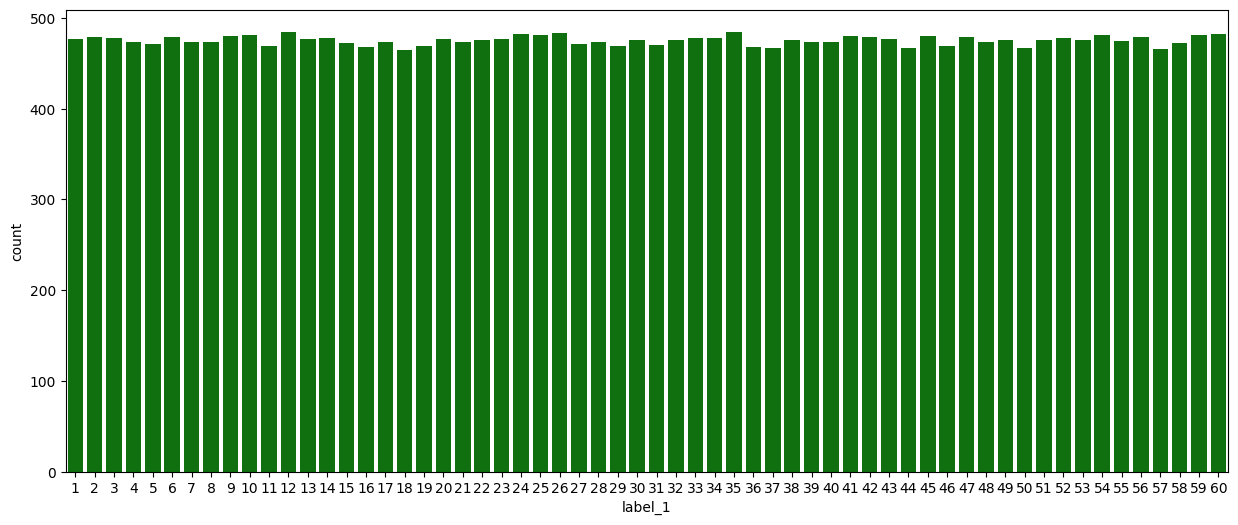

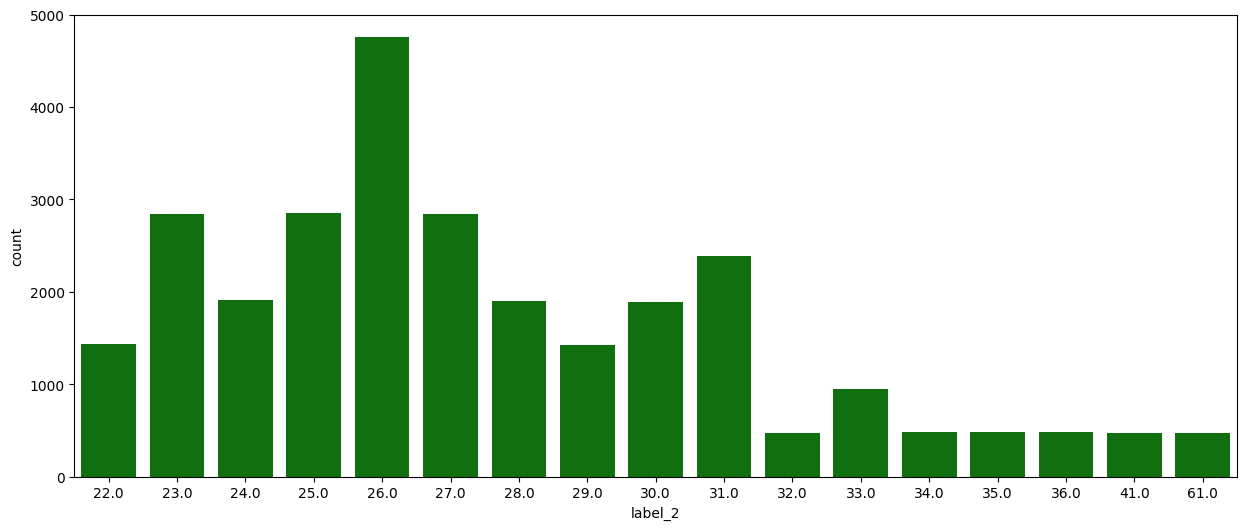

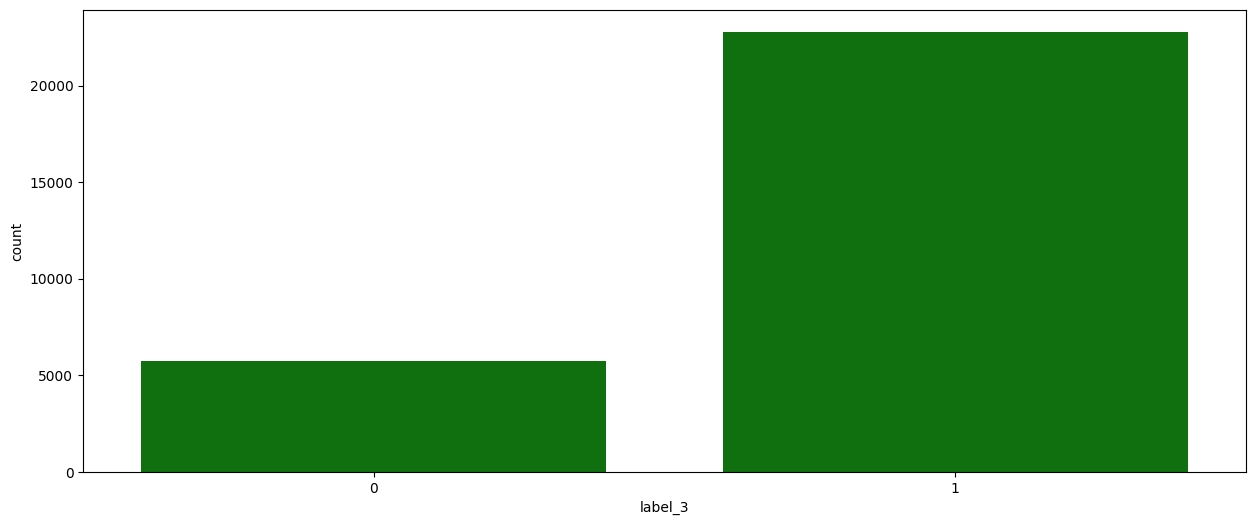

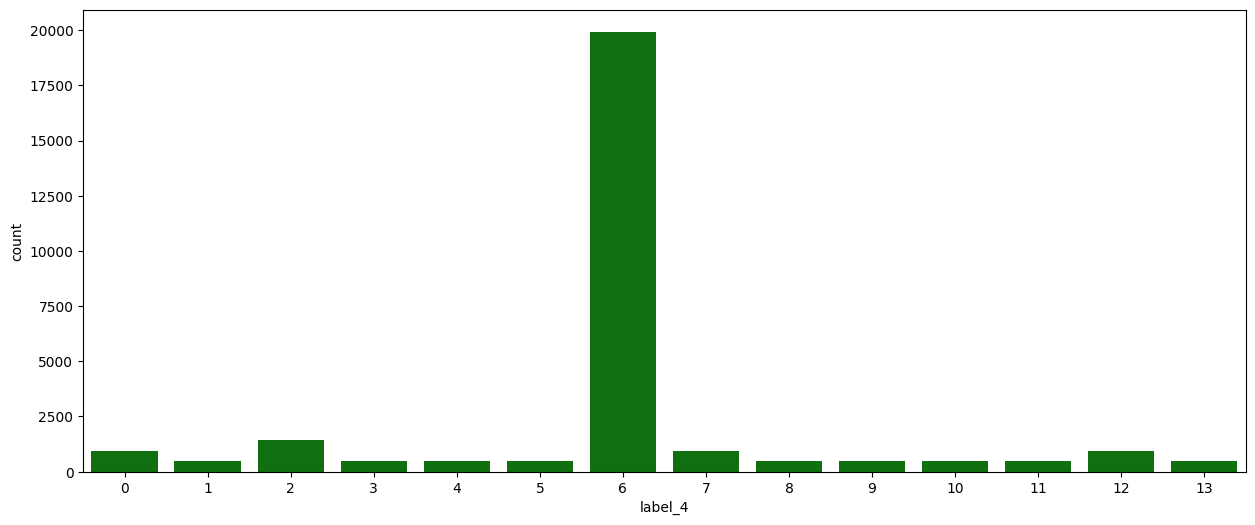

In [12]:
for label in labels:
  feature_selection(label)

In [13]:
X_train_selected['label_1'].shape

(28520, 350)

In [14]:
X_valid_selected['label_1'].shape


(750, 350)

In [15]:
X_test_selected['label_3'].shape

(744, 350)

## Dimensionality reduction using PCA

In [16]:
X_train_pca = {}
X_valid_pca = {}
X_test_pca = {}

In [17]:
from sklearn.decomposition import PCA

def PCA_reduction(L, X_train, X_valid):
  n_components = 0.95

  # Fit PCA on the training data
  pca = PCA(n_components=n_components)
  X_train_pca[L] = pca.fit_transform(X_train[L])

  # Transform validation and test data using the same PCA
  X_valid_pca[L] = pca.transform(X_valid[L])
  X_test_pca[L] = pca.transform(X_test[L])

In [18]:
for label in labels:
  PCA_reduction(label, X_train, X_valid)

In [20]:
X_train_pca['label_1'].shape

(28520, 321)

## Classifier Models

In [21]:
models = ["svm", "xgb", "random_forest"]

In [22]:
def classifier(model, L, X_train, X_valid, y_train, y_valid):
  classifier = None
  class_weight = None if L == labels[0] else 'balanced'
  param_dist = None

  if model == models[0]:
    # Create an SVM classifier
    classifier = SVC(kernel='linear', class_weight=class_weight)
  elif model == models[1]:
    # Create an XGBoost classifier
    classifier = xgb.XGBClassifier()
    # Encode the target variable if needed
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
  elif model == models[2]:
    # Create an random forest classifier
    classifier = RandomForestClassifier()

  classifier.fit(X_train[L], y_train[L])

  y_pred = classifier.predict(X_valid[L])
  accuracy = accuracy_score(y_valid[L], y_pred)
  print(f"{model} Accuracy Score for {L} = ", accuracy)

  return classifier

## Cross validation

In [2]:
def cross_validation(model, L, X, y):
    classifier = None
    class_weight = None if L == labels[0] else 'balanced'

    if model == models[0]:
        # Create an SVM classifier
        classifier = SVC(kernel='linear', class_weight=class_weight)
    elif model == models[1]:
        # Create an XGBoost classifier
        classifier = xgb.XGBClassifier()
        # Encode the target variable if needed
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
    elif model == models[2]:
        # Create an random forest classifier
        classifier = RandomForestClassifier()

    # Perform 5-fold cross-validation
    print(f"5-fold cross validation started for {model}")
    scores = cross_val_score(classifier, X, y, cv=5)
    print(f"5-fold cross validation finished")

    # Print the cross-validation scores
    print("Cross-Validation Scores:", scores)

    # Calculate and print the mean and standard deviation of the scores
    mean_score = np.mean(scores)
    std_deviation = np.std(scores)
    print("Mean Score:", mean_score)
    print("Standard Deviation:", std_deviation)

In [109]:
cross_validation(models[0], labels[0], X_train[labels[0]], y_train[labels[0]])

5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.95038569 0.95021038 0.94915849 0.95056101 0.95108696]
Mean Score: 0.9502805049088359
Standard Deviation: 0.0006330809987821604


In [113]:
cross_validation(models[0], labels[1], X_train[labels[1]], y_train[labels[1]])

5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.39300999 0.54493581 0.60716833 0.60770328 0.41797432]
Mean Score: 0.5141583452211127
Standard Deviation: 0.09195330968023635


In [114]:
cross_validation(models[0], labels[2], X_train[labels[2]], y_train[labels[2]])

5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.97387798 0.99193548 0.98544881 0.98018934 0.99421459]
Mean Score: 0.985133239831697
Standard Deviation: 0.007482833195845332


In [115]:
cross_validation(models[0], labels[3], X_train[labels[3]], y_train[labels[3]])

5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.89621318 0.87464937 0.86395512 0.89849229 0.85957223]
Mean Score: 0.8785764375876578
Standard Deviation: 0.016112483125254675


## Evaluations

#### Before feature engineering

In [23]:
l1_model = classifier(models[0], labels[0], X_train, X_valid, y_train, y_valid)

svm Accuracy Score for label_1 =  0.956


In [24]:
l2_model = classifier(models[0], labels[1], X_train, X_valid, y_train, y_valid)

svm Accuracy Score for label_2 =  0.8233695652173914


In [25]:
l3_model = classifier(models[0], labels[2], X_train, X_valid, y_train, y_valid)

svm Accuracy Score for label_3 =  0.9973333333333333


In [26]:
l4_model = classifier(models[0], labels[3], X_train, X_valid, y_train, y_valid)

svm Accuracy Score for label_4 =  0.94


#### After feature reduction

In [27]:
l1_model = classifier(models[0], labels[0], X_train_selected, X_valid_selected, y_train, y_valid)

svm Accuracy Score for label_1 =  0.9413333333333334


In [28]:
l2_model = classifier(models[0], labels[1], X_train_selected, X_valid_selected, y_train, y_valid)


svm Accuracy Score for label_2 =  0.7567934782608695


In [29]:
l3_model = classifier(models[0], labels[2], X_train_selected, X_valid_selected, y_train, y_valid)

svm Accuracy Score for label_3 =  0.9946666666666667


In [30]:
l4_model = classifier(models[0], labels[3], X_train_selected, X_valid_selected, y_train, y_valid)

svm Accuracy Score for label_4 =  0.8893333333333333


#### *After* dimension reduction

In [31]:
l1_model = classifier(models[0], labels[0], X_train_pca, X_valid_pca, y_train, y_valid)

svm Accuracy Score for label_1 =  0.9533333333333334


In [32]:
l2_model = classifier(models[0], labels[1], X_train_pca, X_valid_pca, y_train, y_valid)

svm Accuracy Score for label_2 =  0.7690217391304348


In [33]:
l3_model = classifier(models[0], labels[2], X_train_pca, X_valid_pca, y_train, y_valid)

svm Accuracy Score for label_3 =  0.9946666666666667


In [34]:
l4_model = classifier(models[0], labels[3], X_train_pca, X_valid_pca, y_train, y_valid)

svm Accuracy Score for label_4 =  0.9133333333333333


## Hyperparameter Tuning

In [35]:
# Model hyperparameters
param_dist_svm = {
    'C': np.logspace(-3, 3, 6),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 5))
}

param_dist_xgboost = {
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 200),
    'max_depth': randint(1, 10),
    'min_child_weight': randint(1, 10),
}

param_dist_random_forest = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
}

In [3]:
def best_classifier(model, L, X_train, X_valid, y_train, y_valid):
  t1 = time.time()
  classifier = None
  class_weight = None if L == labels[0] else 'balanced'
  param_dist = None

  if model == models[0]:
    # Create an SVM classifier
    classifier = SVC(kernel='linear', class_weight=class_weight)
    param_dist = param_dist_svm
  elif model == models[1]:
    # Create an XGBoost classifier
    classifier = xgb.XGBClassifier()
    # Encode the target variable if needed
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    param_dist = param_dist_xgboost
  elif model == models[2]:
    # Create an random forest classifier
    classifier = RandomForestClassifier()
    param_dist = param_dist_random_forest


  # Perform Random Search for each model
  random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, scoring='accuracy', cv=2, verbose=1, random_state=42, n_iter=5, n_jobs=-1)
  print("===========================Random search fit started================================")
  random_search.fit(X_train[L], y_train[L])
  print("===========================Random search fit stopped================================")
  classifier = random_search.best_estimator_  # Get best classifier from random search
  print(f"Best Parameters for {model}:")
  print(random_search.best_params_)
  print(f"Best Accuracy for {model}:")
  print(random_search.best_score_)

  classifier.fit(X_train[L], y_train[L])

  y_pred = classifier.predict(X_valid[L])
  accuracy = accuracy_score(y_valid[L], y_pred)
  print(f"{model} Accuracy Score for {L} = ", accuracy)

  t2 = time.time()
  print(f"Time elapsed: {(t2-t1)/60}mins")

  return classifier

SVM Model Evaluation after hyperparameter tuning

```cv=2```

```random_state=default```

```n_jobs=1```


In [37]:
l1_best_model = best_classifier(models[0], labels[0], X_train_pca, X_valid_pca, y_train, y_valid)

===========================Random search fit started================================
Fitting 2 folds for each of 5 candidates, totalling 10 fits
===========================Random search fit stopped================================
Best Parameters for svm:
{'kernel': 'rbf', 'gamma': 0.001, 'C': 1000.0}
Best Accuracy for svm:
0.9542075736325386
svm Accuracy Score for label_1 =  0.9813333333333333
Time elapsed: 14.244142504533132mins


In [38]:
l2_best_model = best_classifier(models[0], labels[1], X_train_pca, X_valid_pca, y_train, y_valid)

===========================Random search fit started================================
Fitting 2 folds for each of 5 candidates, totalling 10 fits
===========================Random search fit stopped================================
Best Parameters for svm:
{'kernel': 'poly', 'gamma': 'scale', 'C': 3.981071705534969}
Best Accuracy for svm:
0.2559557774607703
svm Accuracy Score for label_2 =  0.9334239130434783
Time elapsed: 19.423761570453642mins


In [39]:
l3_best_model = best_classifier(models[0], labels[2], X_train_pca, X_valid_pca, y_train, y_valid)

===========================Random search fit started================================
Fitting 2 folds for each of 5 candidates, totalling 10 fits
===========================Random search fit stopped================================
Best Parameters for svm:
{'kernel': 'rbf', 'gamma': 0.001, 'C': 63.0957344480193}
Best Accuracy for svm:
0.9734572230014025
svm Accuracy Score for label_3 =  0.996
Time elapsed: 12.957898418108622mins


In [40]:
l4_best_model = best_classifier(models[0], labels[3], X_train_pca, X_valid_pca, y_train, y_valid)

===========================Random search fit started================================
Fitting 2 folds for each of 5 candidates, totalling 10 fits
===========================Random search fit stopped================================
Best Parameters for svm:
{'kernel': 'rbf', 'gamma': 'auto', 'C': 63.0957344480193}
Best Accuracy for svm:
0.8262622720897617
svm Accuracy Score for label_4 =  0.96
Time elapsed: 31.61127141316732mins


SVM Model Evaluation after hyperparameter tuning

```cv=5```

```random_state=42```

```n_jobs=-1```


In [111]:
l1_best_model_1 = best_classifier(models[0], labels[0], X_train_pca, X_valid_pca, y_train, y_valid)

===========================Random search fit started================================
Fitting 5 folds for each of 5 candidates, totalling 25 fits
===========================Random search fit stopped================================
Best Parameters for svm:
{'kernel': 'rbf', 'gamma': 'auto', 'C': 3.981071705534969}
Best Accuracy for svm:
0.9522440392706872
svm Accuracy Score for label_1 =  0.964
Time elapsed: 49.2558887998263mins


## Predictions

Label 1 prediction

In [63]:
# Predict using best SVM model for label 1
y_pred_l1 = l1_best_model.predict(X_test_pca[labels[0]])

In [64]:
# Predict using best SVM model for label 1
y_pred_l2 = l2_best_model.predict(X_test_pca[labels[1]])

In [65]:
# Predict using best SVM model for label 1
y_pred_l3 = l3_best_model.predict(X_test_pca[labels[2]])

In [66]:
# Predict using best SVM model for label 1
y_pred_l4 = l4_best_model.predict(X_test_pca[labels[3]])

## Generate Output CSV Files

Convert predicted label arrays to dataframes

In [90]:
id_column = test_df.iloc[:, :1]
y_pred_l1 = pd.DataFrame(y_pred_l1)
y_pred_l2 = pd.DataFrame(y_pred_l2)
y_pred_l3 = pd.DataFrame(y_pred_l3)
y_pred_l4 = pd.DataFrame(y_pred_l4)

Add colun names

In [91]:
y_pred_l1.columns = [labels[0]]
y_pred_l2.columns = [labels[1]]
y_pred_l3.columns = [labels[2]]
y_pred_l4.columns = [labels[3]]

In [93]:
pd.DataFrame(id_column)

,ID
0,1
1,2
2,3
3,4
4,5
...,...
739,740
740,741
741,742
742,743


Generate submission file

In [94]:
output_dataframe = pd.concat([id_column, y_pred_l1, y_pred_l2, y_pred_l3, y_pred_l4], axis=1)

In [95]:
output_dataframe

,ID,label_1,label_2,label_3,label_4
0,1,26,22.0,0,2
1,2,18,25.0,1,8
2,3,16,30.0,1,6
3,4,7,27.0,1,6
4,5,58,29.0,0,6
...,...,...,...,...,...
739,740,46,30.0,1,6
740,741,35,24.0,1,2
741,742,54,33.0,1,6
742,743,38,32.0,1,12


In [96]:
output_dataframe.to_csv("output.csv", index=False)